In [1]:
#Importing libraries
 
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import pyplot
from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
"""
    DATA PREPARATION
      > Loading the dataset and splitting it into train, cross validation and test sets
      > The inputs are to be in the format of X.shape = (number_of_examples, number_of features)
      > The outputs are to be in the format of y.shape = (number_of_output_units, number_of_examples)
"""
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()

# Preparing the data
Y_tr_resh = Y_train_orig.reshape(60000, 1)
Y_te_resh = Y_test_orig.reshape(10000, 1)
Y_tr_T = to_categorical(Y_tr_resh, num_classes=10)
Y_te_T = to_categorical(Y_te_resh, num_classes=10)
y_tr = Y_tr_T.T
y_te = Y_te_T.T


# Flattening of inputs
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Preprocessing of Inputs
X_tr = X_train_flatten.T / 255.
X_te = X_test_flatten.T / 255.
num_classes = y_tr.shape[0]
m_tr = X_tr.shape[0]
m_te = X_te.shape[0]

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
"""
    ACTIVATION FUNCTIONS
      > Defining the activation functions for the neural network. Note here that 
         the "tanh" activation function is implemented as "tang(x)"
"""
 
def sigmoid(x):
  return (1/(1+np.exp(-x)))
def relu(x):
    return np.maximum(0,x)
def tang(x):
  return np.tanh(x)
def softmax(x):
  soft = np.exp(x)/np.sum(np.exp(x),axis=0)
  return soft

In [4]:
"""
    DEFINING UNITS AND ACTIVATION FUNCTIONS
      > Here the number of units in each layer and as a result the number of layers
         in our neural network is defined in a Python list "layer_dims"
      > Activation functions for each of the layers is also defined in the Python
         list "act_fn"
      > Note here that the length of act_fn is one less than that of the length of
         layer_dims
"""
 
layer_dims = [X_tr.shape[1],150,100,60,30,10,num_classes]
act_fn = ["relu","relu","relu","relu","relu","softmax"]
dropout_vals = [1,0.5,0.6,0.7,0.8,1]

In [5]:
"""
    INITIALISING THE PARAMETERS
      > The parameters of the neural network are 1.Weights and 2.Bias and these
         parameters are tweaked while training the network. 
      > Weights and bias for each of the layers(excluding the input layer) are
         initialised randomly and special weight initialisation techniques are
         used depending on the activation function of the layer.
      > Weights and bias are stored in the Python dictionary "parameters" and the
         weights of the ith layer are stored by keyword Wi and the bias in bi
      > Wi.shape = (number_of_units_in_(i-1)th_layer, number_of_units_in_(i)th_layer)
      > bi.shape = (number_of_units_in_(i)th_layer,1)
      > Arguments - layer_dims,act_fn
"""
 
def initialize_parameters(layer_dims,activation_fn):
  parameters = {}
  relu_init = 2
  tang_init = 1
  for i in range(1,len(layer_dims)):
    if activation_fn[i-1] is "relu":
      initi = relu_init
    if activation_fn[i-1] is "tang":
      initi = tang_init
    parameters["W"+str(i)] = np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(initi/layer_dims[i-1])
    parameters["b"+str(i)] = np.random.randn(layer_dims[i],1)*0.01
  return parameters

In [6]:
"""
    FORWARD PROPAGATION
      > The forward propagation makes a forward pass through the neural net. The
         outputs of all the layers are computed and then the activation
         for that particular layer is calculated.
      > The python dictionaries "outputs" are used to store the output of the dot
         product between the weights and the inputs and "activations" are used to
         store the activations of the outputs of that layer
      > The "outputs" contain keywords of the format Zi for the outputs of the ith
         layer and the "activations" contain keywords of the format Ai for the activations
         of the ith layer based on its activations as specified in "acts_fn"
      > The input data is also stored in A0 and is handy for back propagation
      > Arguments - Input_Data, parameters, activation_fn
"""
 
def forw_prop(X,parameters,activation_fn,dr_out):
  outputs = {}
  activations = {}
  temp_act = {}
  A_prev = X.T
  for o in range(1,len(layer_dims)):
    if activation_fn[o-1] is "relu":
      activ = relu
    if activation_fn[o-1] is "tang":
      activ = tang
    if activation_fn[o-1] is "sigmoid":
      activ = sigmoid
    if activation_fn[o-1] is "softmax":
      activ = softmax
    if dr_out is False:
      outputs["Z" + str(o)] = np.dot(parameters["W" + str(o)],A_prev) + parameters["b"+str(o)]
      activations["A" + str(o)] = activ(outputs["Z" + str(o)])
      A_prev = activations["A" + str(o)]
    else:
      outputs["Z" + str(o)] = np.dot(parameters["W" + str(o)],A_prev) + parameters["b"+str(o)]
      temp_act["A" + str(o)] = activ(outputs["Z" + str(o)])
      activations["A" + str(o)] = temp_act["A" + str(o)]*((np.random.rand(temp_act["A" + str(o)].shape[0],temp_act["A" + str(o)].shape[1]) < dropout_vals[o-1])/dropout_vals[o-1])
      A_prev = activations["A" + str(o)]
  activations["A0"] = X.T
  return outputs,activations

In [7]:
def grad_L1_reg(parameters):
  comp = {}
  for f in range(1,len(layer_dims)):
    comp["W" + str(f)] = np.zeros(parameters["W" + str(f)].shape)
  for k in range(1,len(layer_dims)):
    for p in range(0,parameters["W" + str(k)].shape[0]):
      for n in range(0,parameters["W" + str(k)].shape[1]):
        if parameters["W" + str(k)][p,n] > 0:
          comp["W" + str(k)][p,n] = 1
        else:
          comp["W" + str(k)][p,n] = -1
  return comp

In [8]:
def L1_reg(comp,parameters,lamb,m_exam):
  temp_sum = 0
  grad_reg = {}
  for k in range(1,len(layer_dims)):
    temp_sum = temp_sum + ((lamb/m_exam)*(np.sum(np.sum(parameters["W" + str(k)]))))
    grad_reg["dW" + str(k)] = ((lamb/m_exam)*(comp["W" + str(k)]))
  return temp_sum,grad_reg

def L2_reg(parameters,lamb,m_exam):
  temp_sum = 0
  grad_reg = {}
  for k in range(1,len(layer_dims)):
    temp_sum = temp_sum + ((lamb/(2*m_exam))*(np.sum(np.sum(np.square(parameters["W" + str(k)])))))
    grad_reg["dW" + str(k)] = ((lamb/m_exam)*(parameters["W" + str(k)]))
  return temp_sum,grad_reg

In [9]:
"""
    COST FUNCTION
      > Cost function is calculated using the activations of the final layer of
         the network and the ground truth y
      > Arguments - activation, y, number_of_examples
"""
 
def cost_func(reg,lamb,parameters,A,y,m_exam):
  if reg is not None:
    if reg is "L1":
      comp = grad_L1_reg(parameters)
      temp_sum,grad_reg = L1_reg(comp,parameters,lamb,m_exam)
      cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A)) + ((1-y)*np.log(1-A)))))) + temp_sum
    if reg is "L2":
      temp_sum,grad_reg = L2_reg(parameters,lamb,m_exam)
      cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A)) + ((1-y)*np.log(1-A)))))) + temp_sum
  else:
    grad_reg = {}
    cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A)) + ((1-y)*np.log(1-A))))))
    for r in range(1,len(layer_dims)):
      grad_reg["dW" + str(r)] = 0
  return cost,grad_reg

def cost_func_multi(reg,lamb,parameters,A,y,m_exam):
  if reg is not None:
    if reg is "L1":
      comp = grad_L1_reg(parameters)
      temp_sum,grad_reg = L1_reg(comp,parameters,lamb,m_exam)
      cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A)))))) + temp_sum
    if reg is "L2":
      temp_sum,grad_reg = L2_reg(parameters,lamb,m_exam)
      cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A)))))) + temp_sum
  else:
    grad_reg = {}
    cost = ((-1/m_exam)*(np.sum(np.sum((y*np.log(A))))))
    for r in range(1,len(layer_dims)):
      grad_reg["dW" + str(r)] = 0
  return cost,grad_reg


In [10]:
"""
    GRADIENTS OF ACTIVATION FUNCTIONS
      > Here the gradients of the activation functions are defined.
      > This calculates the derivative of the activation of the ith layer to the
         outputs of the ith layer
      > Arguments - outputs Z
"""
 
def sigmoid_backward(z):
  grad_back = np.exp(-z)/np.square(1+np.exp(-z))
  return grad_back
def relu_backward(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x
def tang_backward(x):
  return (1 - np.square(np.tanh(x)))

In [11]:
"""
    PREDICTIONS
      > The predictions for the outputs of the network are calculated given a
         threshold value for predicting the class of the input data according to
         the parameters learned by the network.
      > Arguments - A(Activations),threshold_for_classification
"""
 
def predict(A,threshold):
  predictions = np.zeros((A.shape))
  for v in range(0,A.shape[0]):
    for w in range(0,A.shape[1]):
      if A[v,w]>threshold:
        predictions[v,w]=1
      else:
        predictions[v,w]=0
  return predictions

def predict_multi(A):
  predictions_multi = np.zeros(A.shape)
  for v in range(0,A.shape[1]):
    temp = max(A[:,v])
    for w in range(0,A.shape[0]):
      if A[w,v] == temp:
        predictions_multi[w,v] = 1
      else:
        predictions_multi[w,v] = 0
  return predictions_multi

In [12]:
def create_mini_batches(X,Y,m_ex,mb_size):
  mini_batch = {}
  num = m_ex//mb_size
  f = 0
  for p in range(0,num):
    mini_batch["MB_X" + str(p)] = X[f:(f+mb_size),:]
    mini_batch["MB_Y" + str(p)] = Y[:,f:(f+mb_size)]
    f = f + mb_size
  mini_batch["MB_X" + str(num)] = X[f:m_ex,:]
  mini_batch["MB_Y" + str(num)] = Y[:,f:m_ex]
  return mini_batch,num

In [13]:
def grad_des(grad_reg,m_examp,alpha,grads,Y,activation_fn,outputs,activations,parameters):
  grads["dA" + str(len(layer_dims)-1)] = (-1/m_examp)*(Y/activations["A" + str(len(layer_dims)-1)])
  grads["dZ" + str(len(layer_dims)-1)] = activations["A" + str(len(layer_dims)-1)] - Y
  grads["dW" + str(len(layer_dims)-1)] = (np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)) + grad_reg["dW" + str(len(layer_dims)-1)]
  grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
  for j in reversed(range(1,len(layer_dims)-1)):
    if activation_fn[j-1] is "relu":
      backward = relu_backward
    if activation_fn[j-1] is "tang":
      backward = tang_backward
    if activation_fn[j-1] is "sigmoid":
      backward = sigmoid_backward
    grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
    grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
    grads["dW" + str(j)] = (np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)) + grad_reg["dW" + str(j)]
    grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
  for k in range(1,len(layer_dims)):
    parameters["W" + str(k)] -= (alpha*(grads["dW" + str(k)]))
    parameters["b" + str(k)] -= (alpha*(grads["db" + str(k)]))
  return parameters

 
def gd_mom(grad_reg,m_examp,V_dict,grads,alpha,beta1,Y,activation_fn,outputs,activations,parameters):
  grads["dA" + str(len(layer_dims)-1)] = (-1/m_examp)*(Y/activations["A" + str(len(layer_dims)-1)])
  grads["dZ" + str(len(layer_dims)-1)] = activations["A" + str(len(layer_dims)-1)] - Y
  grads["dW" + str(len(layer_dims)-1)] = (np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)) + grad_reg["dW" + str(len(layer_dims)-1)]
  grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
  for j in reversed(range(1,len(layer_dims)-1)):
    if activation_fn[j-1] is "relu":
      backward = relu_backward
    if activation_fn[j-1] is "tang":
      backward = tang_backward
    if activation_fn[j-1] is "sigmoid":
      backward = sigmoid_backward
    grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
    grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
    grads["dW" + str(j)] = (np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)) + grad_reg["dW" + str(j)]
    grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
  for h in range(1,len(layer_dims)):
    V_dict["Vdw" + str(h)] = (beta1*V_dict["Vdw" + str(h)]) + ((1-beta1)*grads["dW" + str(h)])
    V_dict["Vdb" + str(h)] = (beta1*V_dict["Vdb" + str(h)]) + ((1-beta1)*grads["db" + str(h)])
  for g in range(1,len(layer_dims)):
    parameters["W" + str(g)] -= (alpha*(V_dict["Vdw" + str(g)]))
    parameters["b" + str(g)] -= (alpha*(V_dict["Vdb" + str(g)]))
  return parameters
 
 
def rms_prop(grad_reg,m_examp,S_dict,grads,epsilon,alpha,beta2,Y,activation_fn,outputs,activations,parameters):
  grads["dA" + str(len(layer_dims)-1)] = (-1/m_examp)*(Y/activations["A" + str(len(layer_dims)-1)])
  grads["dZ" + str(len(layer_dims)-1)] = activations["A" + str(len(layer_dims)-1)] - Y
  grads["dW" + str(len(layer_dims)-1)] = (np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)) + grad_reg["dW" + str(len(layer_dims)-1)]
  grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
  for j in reversed(range(1,len(layer_dims)-1)):
    if activation_fn[j-1] is "relu":
      backward = relu_backward
    if activation_fn[j-1] is "tang":
      backward = tang_backward
    if activation_fn[j-1] is "sigmoid":
      backward = sigmoid_backward
    grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
    grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
    grads["dW" + str(j)] = (np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)) + grad_reg["dW" + str(j)]
    grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
  for h in range(1,len(layer_dims)):
    S_dict["Sdw" + str(h)] = (beta2*S_dict["Sdw" + str(h)]) + ((1-beta2)*np.square(grads["dW" + str(h)]))
    S_dict["Sdb" + str(h)] = (beta2*S_dict["Sdb" + str(h)]) + ((1-beta2)*np.square(grads["db" + str(h)]))
  for g in range(1,len(layer_dims)):
    parameters["W" + str(g)] -= ((alpha*grads["dW" + str(g)])/(np.sqrt(S_dict["Sdw" + str(g)]) + epsilon))
    parameters["b" + str(g)] -= ((alpha*grads["db" + str(g)])/(np.sqrt(S_dict["Sdb" + str(g)]) + epsilon))
  return parameters
 
def adam(grad_reg,t,m_examp,epsilon,grads,V_dict,S_dict,alpha,beta1,beta2,Y,activation_fn,outputs,activations,parameters):
  S_dict_corr = {}
  V_dict_corr = {}
  grads["dA" + str(len(layer_dims)-1)] = (-1/m_examp)*(Y/activations["A" + str(len(layer_dims)-1)])
  grads["dZ" + str(len(layer_dims)-1)] = activations["A" + str(len(layer_dims)-1)] - Y
  grads["dW" + str(len(layer_dims)-1)] = (np.dot(grads["dZ" + str(len(layer_dims)-1)],activations["A" + str(len(layer_dims)-2)].T)) + grad_reg["dW" + str(len(layer_dims)-1)]
  grads["db" + str(len(layer_dims)-1)] = np.sum(grads["dZ" + str(len(layer_dims)-1)],axis=1,keepdims=True)
  for j in reversed(range(1,len(layer_dims)-1)):
    if activation_fn[j-1] is "relu":
      backward = relu_backward
    if activation_fn[j-1] is "tang":
      backward = tang_backward
    if activation_fn[j-1] is "sigmoid":
      backward = sigmoid_backward
    grads["dA" + str(j)] = np.dot(parameters["W" + str(j+1)].T,grads["dZ" + str(j+1)])
    grads["dZ" + str(j)] = grads["dA" + str(j)]*backward(outputs["Z" + str(j)])
    grads["dW" + str(j)] = (np.dot(grads["dZ" + str(j)],activations["A" + str(j-1)].T)) + grad_reg["dW" + str(j)]
    grads["db" + str(j)] = np.sum(grads["dZ" + str(j)],axis=1,keepdims=True)
  for h in range(1,len(layer_dims)):
    V_dict["Vdw" + str(h)] = (beta1*V_dict["Vdw" + str(h)]) + ((1-beta1)*grads["dW" + str(h)])
    V_dict["Vdb" + str(h)] = (beta1*V_dict["Vdb" + str(h)]) + ((1-beta1)*grads["db" + str(h)])
  for c in range(1,len(layer_dims)):
    S_dict["Sdw" + str(c)] = (beta2*S_dict["Sdw" + str(c)]) + ((1-beta2)*np.square(grads["dW" + str(c)]))
    S_dict["Sdb" + str(c)] = (beta2*S_dict["Sdb" + str(c)]) + ((1-beta2)*np.square(grads["db" + str(c)]))
  for n in range(1,len(layer_dims)):
    S_dict_corr["Sdw" + str(n)] = S_dict["Sdw" + str(n)]/(1 - np.power(beta2,t))
    S_dict_corr["Sdb" + str(n)] = S_dict["Sdb" + str(n)]/(1 - np.power(beta2,t))
    V_dict_corr["Vdw" + str(n)] = V_dict["Vdw" + str(n)]/(1 - np.power(beta1,t))
    V_dict_corr["Vdb" + str(n)] = V_dict["Vdb" + str(n)]/(1 - np.power(beta1,t))
  for g in range(1,len(layer_dims)):
    parameters["W" + str(g)] -= ((alpha*V_dict["Vdw" + str(g)])/(np.sqrt(S_dict_corr["Sdw" + str(g)]) + epsilon))
    parameters["b" + str(g)] -= ((alpha*V_dict["Vdb" + str(g)])/(np.sqrt(S_dict_corr["Sdb" + str(g)]) + epsilon))
  return parameters

In [14]:
"""
    PRECISION RECALL AND F1 SCORE
      > Function is defined to calculate the precision, recall and F1 scores of the test and
         cross validation data
      > Returns the precision, recall and F1 score
      > Arguments - Predictions_of_the_final_activation, y(ground_truth)
"""
 
def prec_rec(A,y):
  epsilon = 1e-5
  tp = 0
  fp = 0
  fn = 0
  for i in range(0,y.shape[1]):
    if ((A[0,i]==1) and (y[0,i]==1)):
      tp = tp+1
    if ((A[0,i]==1) and (y[0,i]==0)):
      fp = fp+1
    if ((A[0,i]==0) and (y[0,i]==1)):
      fn = fn+1
  prec = tp/(tp+fp+epsilon)
  rec = tp/(tp+fn+epsilon)
  f1 = (2*prec*rec)/(prec+rec+epsilon)
  return prec,rec,f1

In [15]:
def prec_rec_multi(A,y):
  epsilon = 1e-5
  tp_multi = {}
  fp_multi = {}
  fn_multi = {}
  prec_multi = {}
  rec_multi = {}
  f1_multi = {}
  for r in range(0,num_classes):
    tp_multi["class" + str(r)] = 0
    fp_multi["class" + str(r)] = 0
    fn_multi["class" + str(r)] = 0
  for c in range(0,y.shape[1]):
    for g in range(0,y.shape[0]):
      if ((A[g,c]==1) and (y[g,c]==1)):
        tp_multi["class" + str(g)] = tp_multi["class" + str(g)] + 1
      if ((A[g,c]==1) and (y[g,c]==0)):
        fp_multi["class" + str(g)] = fp_multi["class" + str(g)] + 1
      if ((A[g,c]==0) and (y[g,c]==1)):
        fn_multi["class" + str(g)] = fn_multi["class" + str(g)] + 1
  for n in range(0,num_classes):
    prec_multi["class" + str(n)] = tp_multi["class" + str(n)] / (tp_multi["class" + str(n)] + fp_multi["class" + str(n)] + epsilon)
    rec_multi["class" + str(n)] = tp_multi["class" + str(n)] / (tp_multi["class" + str(n)] + fn_multi["class" + str(n)] + epsilon)
    f1_multi["class" + str(n)] = (2*prec_multi["class" + str(n)]*rec_multi["class" + str(n)])/(prec_multi["class" + str(n)] + rec_multi["class" + str(n)] + epsilon)
  return prec_multi,rec_multi,f1_multi

In [16]:
"""
    PERFORMANCE ON TEST AND CROSS VALIDATION DATA
      > This function evaluates the performance of the learning algorithm on test
         and cross validation data
      > Returns the accuracy, precision, recall and F1 score of test and cross validation
         datasets
      > Arguments - X,y,trained_parameters,print_values(True/False)
"""
 
""" 
def cross_val(X,y,params_tr,print_values):
  out_cv,act_cv = forw_prop(X,params_tr,act_fn,False)
  predictions_cv = predict(act_cv["A" + str(len(layer_dims)-1)],0.5)
  accu_cv = float(np.mean(predictions_cv==y,axis=1))*100
  prec_cv,rec_cv,f1_cv = prec_rec(predictions_cv,y)
  if print_values is True:
    print("CROSS VAL RESULTS: ")
    print("Cross val accuracy = " + str(accu_cv))
    print("Precision: " + str(prec_cv))
    print("Recall: " + str(rec_cv))
    print("F1 score: " + str(f1_cv))
    print('\n')
    print('\n')
  return accu_cv,prec_cv,rec_cv,f1_cv"""
def test(X,y,params_tr,print_values):
  out_te,act_te = forw_prop(X,params_tr,act_fn,False)
  predictions_te = predict(act_te["A" + str(len(layer_dims)-1)],0.5)
  accu_te = float(np.mean(predictions_te==y,axis=1))*100
  prec_te,rec_te,f1_te = prec_rec(predictions_te,y)
  if print_values is True:
    print("TEST RESULTS: ")
    print("Testing accuracy = " + str(accu_te))
    print("Precision: " + str(prec_te))
    print("Recall: " + str(rec_te))
    print("F1 score: " + str(f1_te))
    print('\n')
    print('\n')
  return accu_te,prec_te,rec_te,f1_te

"""
def cross_val_multi(X,y,params_tr,print_values):
  out_cv,act_cv = forw_prop(X,params_tr,act_fn,False)
  predictions_cv = predict_multi(act_cv["A" + str(len(layer_dims)-1)])
  accu_cv_arr = []
  for h in range(0,predictions_cv.shape[1]):
    for g in range(0,predictions_cv.shape[0]):
      if ((predictions_cv[g,h]==1) and (y[g,h]==1)):
        accu_cv_arr.append(1)
  accu_cv = np.mean(accu_cv_arr,axis=1)
  prec_cv,rec_cv,f1_cv = prec_rec_multi(predictions_cv,y)
  prec_avg_cv = 0
  rec_avg_cv = 0
  f1_avg_cv = 0
  for h in range(0,num_classes):
    prec_avg_cv = prec_avg_cv + prec_cv["class" + str(h)]
    rec_avg_cv = rec_avg_cv + rec_cv["class" + str(h)]
    f1_avg_cv = f1_avg_cv + f1_cv["class" + str(h)]
  prec_avg_cv = prec_avg_cv/num_classes
  rec_avg_cv = rec_avg_cv/num_classes
  f1_avg_cv = f1_avg_cv/num_classes

  if print_values is True:
    print("CROSS VAL RESULTS: ")
    print("Cross val accuracy = " + str(accu_cv))
    print("Precision: " + str(prec_avg_cv))
    print("Recall: " + str(rec_avg_cv))
    print("F1 score: " + str(f1_avg_cv))
    print('\n')
    print('\n')
  return accu_cv,prec_avg_cv,rec_avg_cv,f1_avg_cv"""

def test_multi(X,y,params_tr,print_values):
  out_te,act_te = forw_prop(X,params_tr,act_fn,False)
  predictions_te = predict_multi(act_te["A" + str(len(layer_dims)-1)])
  ones_arr = np.ones(predictions_te.shape)
  temp1 = predictions_te==ones_arr
  ind = []
  for gee in range(0,temp1.shape[1]):
    for jee in range(0,temp1.shape[0]):
      if temp1[jee,gee] == True:
        ind.append(jee)
  ind_arr = np.array(ind)
  accu_te = float(np.mean(ind_arr == Y_te_resh.T))*100
  prec_te,rec_te,f1_te = prec_rec_multi(predictions_te,y)
  prec_avg_te = 0
  rec_avg_te = 0
  f1_avg_te = 0
  for h in range(0,num_classes):
    prec_avg_te = prec_avg_te + prec_te["class" + str(h)]
    rec_avg_te = rec_avg_te + rec_te["class" + str(h)]
    f1_avg_te = f1_avg_te + f1_te["class" + str(h)]
  prec_avg_te = prec_avg_te/num_classes
  rec_avg_te = rec_avg_te/num_classes
  f1_avg_te = f1_avg_te/num_classes

  if print_values is True:
    print("TEST RESULTS: ")
    print("Test accuracy = " + str(accu_te))
    print("Precision: " + str(prec_avg_te))
    print("Recall: " + str(rec_avg_te))
    print("F1 score: " + str(f1_avg_te))
    print('\n')
    print('\n')
  return accu_te,prec_avg_te,rec_avg_te,f1_avg_te

In [17]:
"""
    FIT
      > This function is used to train the network on training data and the weights
         are updated by backpropagation through Optimization functions (Gradient descent,RMSprop,Adam)
      > Returns "costs" a Python list consisting of all the costs through the iterations
         and the updated "parameters" dictionary
      > Returns the "master_cache" which contains the values of outputs, activations,
         parameters throughout the training period of the format "master_cache["Z" + str(j) + str(_) + str(i)]
         returns the outputs of the jth layer in the ith iteration of training"
      > Arguments - X(train),Y(train),number_of_training_examples,number_of_iterations,
         learning_rate,parameters,activation_fn,print_cost(True/False),callback
"""
 
def fit(reg,lamb,X,Y,y_classes,m_ex,num_iterations,alpha,mb,optim,params,activation_fn,dr_out,print_cost,callback=None):
  costs = []
  costs_cache = []
  accu_tr_arr = []
  if mb is True:
    mini_batches,num = create_mini_batches(X,Y,m_ex,mb_size)
  p = 0
  m = 0
  if (num_iterations>=1000):
    freq = 100
  elif ((num_iterations<=500) and (num_iterations>=100)):
    freq = 10
  elif ((num_iterations>500) and (num_iterations<1000)):
    freq = 20
  else:
    freq = 1
  V_dict = {}
  S_dict = {}
  for k in range(1,len(layer_dims)):
    V_dict["Vdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
    V_dict["Vdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
    S_dict["Sdw" + str(k)] = np.zeros(params["W" + str(k)].shape)
    S_dict["Sdb" + str(k)] = np.zeros(params["b" + str(k)].shape)
  
  for i in range(1,num_iterations+1):
    
    if ((((optim is "BGD") or (optim is "Momentum")) or ((optim is "RMSprop") or (optim is "Adam"))) and (mb is False)):
      grads = {}
      accu_arr = []
      outputs,activations = forw_prop(X,params,activation_fn,dr_out)
      cost,grad_regs = cost_func_multi(reg,lamb,params,activations["A" + str(len(layer_dims)-1)],Y,m_ex)
      costs.append(cost)
      costs_cache.append(cost)
      predictions_multi = predict_multi(activations["A" + str(len(layer_dims)-1)])
      ones_array = np.ones(predictions_multi.shape)
      temp1 = predictions_multi==ones_array
      ind = []
      for gee in range(0,temp1.shape[1]):
        for jee in range(0,temp1.shape[0]):
          if temp1[jee,gee] == True:
            ind.append(jee)
      if optim == "BGD":
        params = grad_des(grad_regs,m_ex,alpha,grads,Y,activation_fn,outputs,activations,params)
      if optim == "Momentum":
        params = gd_mom(grad_regs,m_ex,V_dict,grads,alpha,0.9,Y,activation_fn,outputs,activations,params)
      if optim == "RMSprop":
        params = rms_prop(grad_regs,m_ex,S_dict,grads,1e-8,alpha,0.999,Y,activation_fn,outputs,activations,params)
      if optim == "Adam":
        params = adam(grad_regs,i,m_ex,1e-8,grads,V_dict,S_dict,alpha,0.9,0.999,Y,activation_fn,outputs,activations,params)
      ind_arr = np.array(ind)
      accu_tr = float(np.mean(ind_arr == Y_tr_resh.T))*100
      accu_tr_arr.append(accu_tr)

    if ((((optim is "mBGD") or (optim is "Momentum")) or ((optim is "RMSprop") or (optim is "Adam"))) and (mb is True)):
      accu_arr = []
      ind = []
      for u in range(0,num+1):
        grads = {}
        outputs,activations = forw_prop(mini_batches["MB_X" + str(u)],params,activation_fn,dr_out)
        cost,grad_regs = cost_func_multi(reg,lamb,params,activations["A" + str(len(layer_dims)-1)],mini_batches["MB_Y" + str(u)],mini_batches["MB_X" + str(u)].shape[0])
        costs_cache.append(cost)
        predict_MB_multi = predict_multi(activations["A" + str(len(layer_dims)-1)])
        ones_array = np.ones(predict_MB_multi.shape)
        temp1 = predict_MB_multi==ones_array
        for gee in range(0,temp1.shape[1]):
          for jee in range(0,temp1.shape[0]):
            if temp1[jee,gee] == True:
              ind.append(jee)
        if optim == "mBGD":
          params = grad_des(grad_regs,mini_batches["MB_Y" + str(u)].shape[1],alpha,grads,mini_batches["MB_Y" + str(u)],activation_fn,outputs,activations,params)
        if optim == "Momentum":
          params = gd_mom(grad_regs,mini_batches["MB_Y" + str(u)].shape[1],V_dict,grads,alpha,0.9,mini_batches["MB_Y" + str(u)],activation_fn,outputs,activations,params)
        if optim == "RMSprop":
          params = rms_prop(grad_regs,mini_batches["MB_Y" + str(u)].shape[1],S_dict,grads,1e-8,alpha,0.999,mini_batches["MB_Y" + str(u)],activation_fn,outputs,activations,params)
        if optim == "Adam":
          params = adam(grad_regs,i,mini_batches["MB_Y" + str(u)].shape[1],1e-8,grads,V_dict,S_dict,alpha,0.9,0.999,mini_batches["MB_Y" + str(u)],activation_fn,outputs,activations,params)
      m = m+1
      ind_arr = np.array(ind)
      accu_tr = float(np.mean(ind_arr == y_classes))*100
      accu_tr_arr.append(accu_tr)
      temp = costs_cache[(num*m)+(m-1)]
      costs.append(temp)

    if optim is "SGD":
      accu_arr = []
      ind = []
      for q in range(0,m_ex):
        grads = {}
        x = X[q,:]
        x = x.reshape(1,2)
        y = Y[:,q]
        y = y.reshape(1,1)
        outputs,activations = forw_prop(x,params,activation_fn,dr_out)
        cost,grad_regs = cost_func_multi(reg,lamb,params,activations["A" + str(len(layer_dims)-1)],Y[:,q],1)
        costs_cache.append(cost)
        params = grad_des(grad_regs,1,alpha,grads,y,activation_fn,outputs,activations,params)
        predict_SGD_multi = predict_multi(activations["A" + str(len(layer_dims)-1)])
        ones_array = np.ones(predict_SGD_multi.shape)
        temp1 = predict_SGD_multi==ones_array
        for gee in range(0,temp1.shape[1]):
          for jee in range(0,temp1.shape[0]):
            if temp1[jee,gee] == True:
              ind.append(jee)
      ind_arr = np.array(ind)
      accu_tr = float(np.mean(ind_arr == y_classes.T))*100
      accu_tr_arr.append(accu_tr)
      m = m+1
      temp = costs_cache[(m_ex*m)-1]
      costs.append(temp)
    
    if ((print_cost is True) and (i%1==0)):
        print("Cost after iteration " + str(i) + " is " + str(costs[p]) + " ------- " + "Training accuracy = " + str(accu_tr_arr[p]))
    p = p+1
    if(i % 1 == 0):
      if(callback is not None):
                callback(i, params)
  return costs, costs_cache, params

In [18]:
#Training the network

mb_size = 1024
parameters_dat = initialize_parameters(layer_dims,act_fn)
"""
outputs,activations = forw_prop(X_tr,parameters_dat,act_fn,False)
cost,grad_regs = cost_func_multi(None,0,parameters_dat,activations["A" + str(len(layer_dims)-1)],y_tr,m_tr)
print(cost)"""
costs,costs_cache,parameters = fit(None,0,X_tr,y_tr,Y_tr_resh.T,m_tr,25,0.005,True,"Adam",parameters_dat,act_fn,False,print_cost=True)

Cost after iteration 1 is 0.4496501203334767 ------- Training accuracy = 60.50833333333333
Cost after iteration 2 is 0.23583424634084169 ------- Training accuracy = 89.44
Cost after iteration 3 is 0.17382992171724862 ------- Training accuracy = 93.32333333333334
Cost after iteration 4 is 0.1539949897328573 ------- Training accuracy = 94.8
Cost after iteration 5 is 0.1383584799819641 ------- Training accuracy = 95.70166666666667
Cost after iteration 6 is 0.12216901598442088 ------- Training accuracy = 96.37333333333333
Cost after iteration 7 is 0.11656509997817713 ------- Training accuracy = 96.87
Cost after iteration 8 is 0.11317471807368196 ------- Training accuracy = 97.245
Cost after iteration 9 is 0.1061061394638028 ------- Training accuracy = 97.39333333333333
Cost after iteration 10 is 0.09409307844741159 ------- Training accuracy = 97.34333333333333
Cost after iteration 11 is 0.08767513659051727 ------- Training accuracy = 97.97166666666666
Cost after iteration 12 is 0.076489039

In [27]:
out_te, act_te = forw_prop(X_te,parameters,act_fn, False)
predictions_te = predict_multi(act_te["A" + str(len(layer_dims) - 1)])
ones_arr = np.ones(predictions_te.shape)
temp1 = predictions_te == ones_arr
ind = []
for gee in range(0, temp1.shape[1]):
    for jee in range(0, temp1.shape[0]):
        if temp1[jee, gee] == True:
            ind.append(jee)
ind_arr = np.array(ind)

Text(0.5, 1.0, 'Digit Label: [1] Predicted Label: 1')

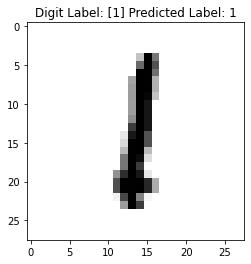

In [37]:
foo = 5646
second_image = X_test_orig[foo, :]
second_label = Y_te_resh[foo]
second_pred_label = ind_arr[foo]
plt.imshow(second_image, cmap='gray_r')
plt.title('Digit Label: {} Predicted Label: {}'.format(second_label,second_pred_label))

In [ ]:
test_multi(X_te,y_te,parameters,print_values=True)

TEST RESULTS: 
Test accuracy = 97.32
Precision: 0.9730947875619205
Recall: 0.973109597263155
F1 score: 0.9730115486996492






(97.32, 0.9730947875619205, 0.973109597263155, 0.9730115486996492)

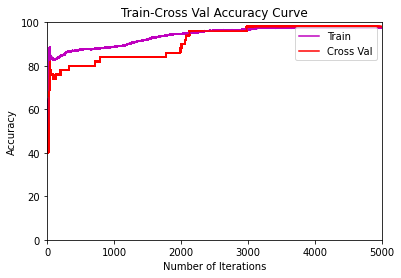

In [ ]:
itera = np.arange(1,len(costs)+1)
def animate_plot(x_ax,y_ax,X_lab,Y_lab,plot_title,leg,loca,plot_col,direc,freq):
  y_vals = y_ax
  x_vals = x_ax
  plt.axes(xlim=(0,len(x_vals)),ylim=(0,max(y_vals)))
  l = 0
  for k in range(1,len(x_vals)+1):
    plt.xlabel(X_lab)
    plt.ylabel(Y_lab)
    plt.title(plot_title)
    plt.legend([leg],loc=loca)
    plt.plot(x_vals[0:l],y_vals[0:l],color=plot_col)
    l = l+1
    if k%freq==0:
      plt.savefig(direc + 'plot{}.png'.format(k//freq))
  return

"""def animate_plot_multi(x_ax,y_ax,X_lab,Y_lab,plot_title,leg,loca,plot_col,direc,freq):
  x_vals = {}
  y_vals = {}
  for m in range(0,len(x_ax)):
    x_vals["X" + str(m)] = x_ax[m]
  for g in range(0,len(y_ax)):
    y_vals["Y" + str(g)] = y_ax[g]
  plt.axes(xlim=(0,len(x_ax[0])),ylim=(0,100))
  for h in range(0,len(leg)):
    plt.plot([],[],color=plot_col[h],label = leg[h])
  plt.legend(loc=loca)
  l = 0
  for k in range(1,len(x_ax[0])+1):
    plt.xlabel(X_lab)
    plt.ylabel(Y_lab)
    plt.title(plot_title)
    for d in range(0,len(x_ax)):
      plt.plot(x_vals["X" + str(d)][0:l],y_vals["Y" + str(d)][0:l],color=plot_col[d])
    l = l+1
    if k%freq==0:
      plt.savefig(direc + 'plot{}.png'.format(k//freq))
  return"""
animate_plot_multi([itera,itera],[accu_tr_arr,accu_cv_arr],'Number of Iterations','Accuracy','Train-Cross Val Accuracy Curve',['Train', 'Cross Val'],'upper right',['m','r'],'/content/drive/My Drive/Colab Notebooks/nn_visuals/fun4/',50)

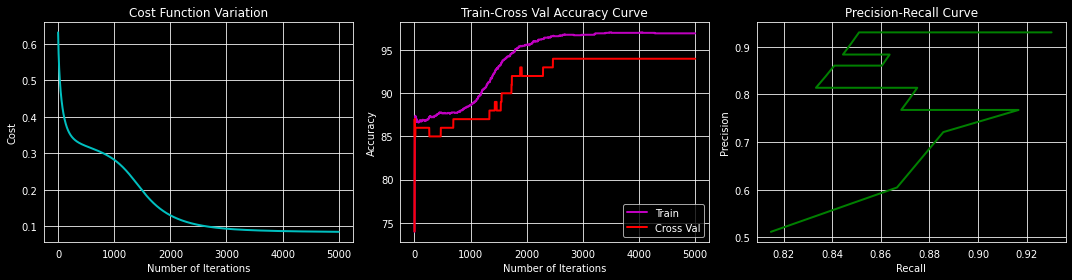

In [ ]:
#Group Plots

itera = np.arange(1,len(costs)+1,1)
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].set_xlabel('Number of Iterations')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost Function Variation')
axs[0].plot(itera,costs,color='c',linewidth=2)
plt.tight_layout()
axs[1].set_xlabel('Number of Iterations')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Train-Cross Val Accuracy Curve')
axs[1].plot(itera,accu_tr_arr,color='m',label='Train',linewidth=2)
axs[1].plot(itera,accu_cv_arr,color='r',label='Cross Val',linewidth=2)
axs[1].legend(loc='lower right')
plt.tight_layout()
axs[2].set_xlabel('Recall')
axs[2].set_ylabel('Precision')
axs[2].set_title('Precision-Recall Curve')
axs[2].plot(prec_cv_arr,rec_cv_arr,color='g',linewidth=2)
plt.tight_layout()

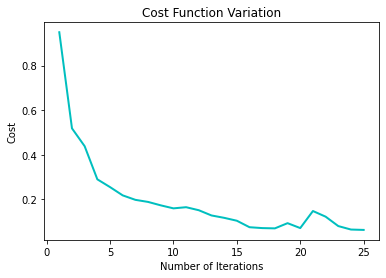

In [ ]:
#Plotting Cost vs Number of Iterations

itera = np.arange(1,len(costs)+1,1)
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Variation')
plt.plot(itera,costs,color='c',linewidth=2)

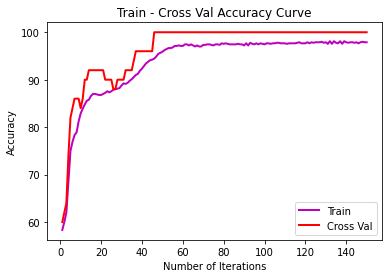

In [ ]:
#Plotting Training accuracy vs Cross-validation accuracy

itera = np.arange(1,len(costs)+1,1)
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Train - Cross Val Accuracy Curve')
plt.plot(itera,accu_tr_arr,color='m',linewidth=2)
plt.plot(itera,accu_cv_arr,color='r',linewidth=2)
plt.legend(["Train","Cross Val"],loc="lower right")

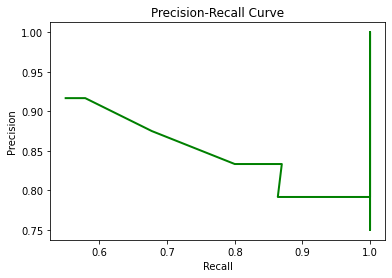

In [ ]:
#Plotting Precision vs Recall

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.plot(prec_cv_arr,rec_cv_arr,color='g',linewidth=2)

In [ ]:
#Decision Boundary Visualisation helper functions
#Remember to set the path to which the graphs should be stored in "OUTPUT_DIR"

sns.set_style("whitegrid")
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
OUTPUT_DIR = "/content/drive/My Drive/Colab Notebooks/nn_visuals/fun5"
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2,-1)
XX, YY = grid
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
import os
def callback_numpy_plot(index, init_params):
    plot_title = "Iteration {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//1)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    out,act = forw_prop(np.transpose(grid_2d),init_params,act_fn,False)
    prediction_probs = act["A" + str(len(layer_dims)-1)]
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_te, y_te, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [ ]:
#Decision Boundary Visualisation

mb_size = 16
layer_dims_vis = layer_dims
layer_dims_vis[0] = 2
parameters_dat = initialize_parameters(layer_dims_vis,act_fn)
_,_,params_values,_,_,_,_ = fit("L2",0.09,X_tr,y_tr,m_tr,5000,0.005,False,"SGD",parameters_dat,act_fn,True,print_cost=False,callback=callback_numpy_plot)

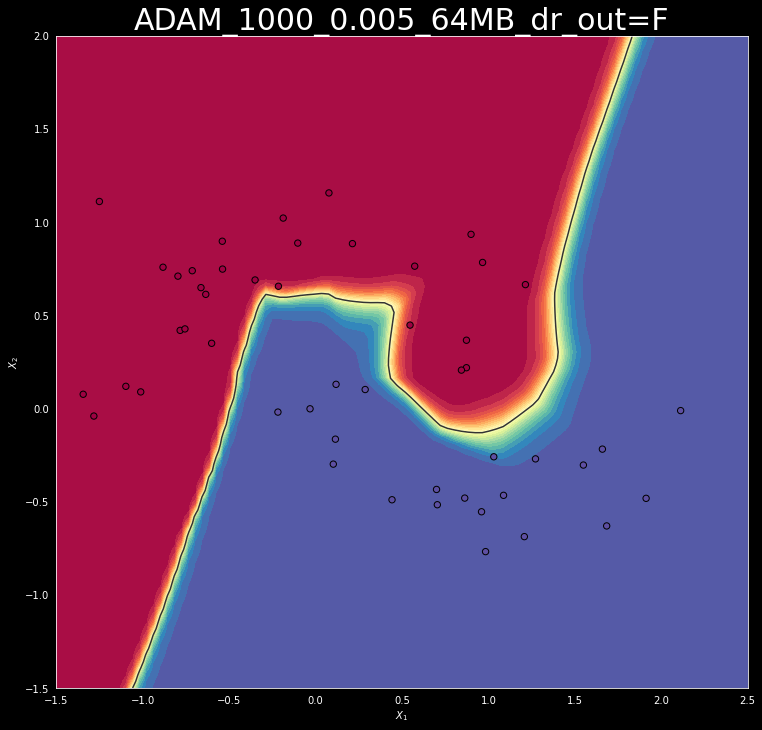

In [ ]:
#Get the final Decision Boundary at the end of training evaluated on the test set 

out,act = forw_prop(np.transpose(grid_2d),params_values,act_fn,False)
prediction_probs_np = act["A" + str(len(layer_dims)-1)]
prediction_probs_np = prediction_probs_np.reshape(prediction_probs_np.shape[1], 1)
make_plot(X_te, y_te, "ADAM_1000_0.005_64MB_dr_out=F", file_name=None, XX=XX, YY=YY, preds=prediction_probs_np, dark=True)